# Comparativa gráfica de múltiples clasificadores

In [1]:
# las libs basicas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# algunos utiles
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

# Los clasificadores
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
# Definimos los nombres de los clasificadores que vamos a usar
nombres = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

# Lista de los modelos y sus parametros
clasificadores = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

print nombres


['Nearest Neighbors', 'Linear SVM', 'RBF SVM', 'Gaussian Process', 'Decision Tree', 'Random Forest', 'Neural Net', 'AdaBoost', 'Naive Bayes', 'QDA']


## Creamos unos Datasets sintéticos

Vamos a crear 3 dataset sinteticos:

- Linealmente separable pero con ruido
- Unos arcos que no son linelamente separables y con ruido
- Un par de circulos concentricos con ruido


In [3]:
# Linealmente separable
#-------------------------
# Usamos make_classification (por defecto crea una matriz de 100 elementos 
# con 2 clases en este caso, y sus etiquetas)
X, y = make_classification(n_features=2, 
                           n_redundant=0, 
                           n_informative=2,
                           random_state=1, 
                           n_clusters_per_class=1)

print X.shape
print y.shape

(100, 2)
(100,)


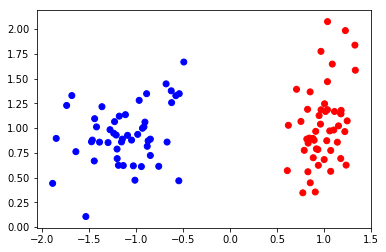

In [4]:
# Ploteamos los datos...
colors = ['red','blue']
plt.scatter(X[:,0], X[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

In [5]:
# Les agregamos ruido
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

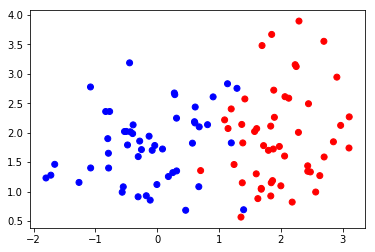

In [6]:
# Ploteamos de nuevo para ver como se mezclan un poco...
colors = ['red','blue']
plt.scatter(X[:,0], X[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

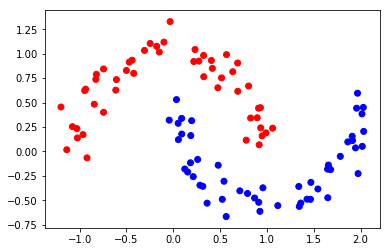

In [7]:
# Ahora reamos otro dataset con 2 semicirculos no concentricos
# por defecto crea un dataset X de 100 muestras x 2 y tambien crea sus etiquetas
X,y=make_moons(noise=0.1)
colors = ['red','blue']
plt.scatter(X[:,0], X[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

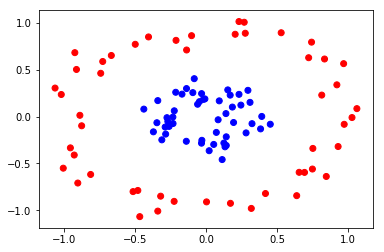

In [8]:
# Ahora hacemos unos circulos concentricos con algo de ruido
X,y=make_circles(noise=0.1, factor=0.3, random_state=1)
colors = ['red','blue']
plt.scatter(X[:,0], X[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

# Cargamos los Datasets en una lista para procesarlos

In [9]:
datasets = [make_moons(noise=0.1),
            make_circles(noise=0.1, factor=0.3, random_state=1),
            linearly_separable
            ]

/home/jorge/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


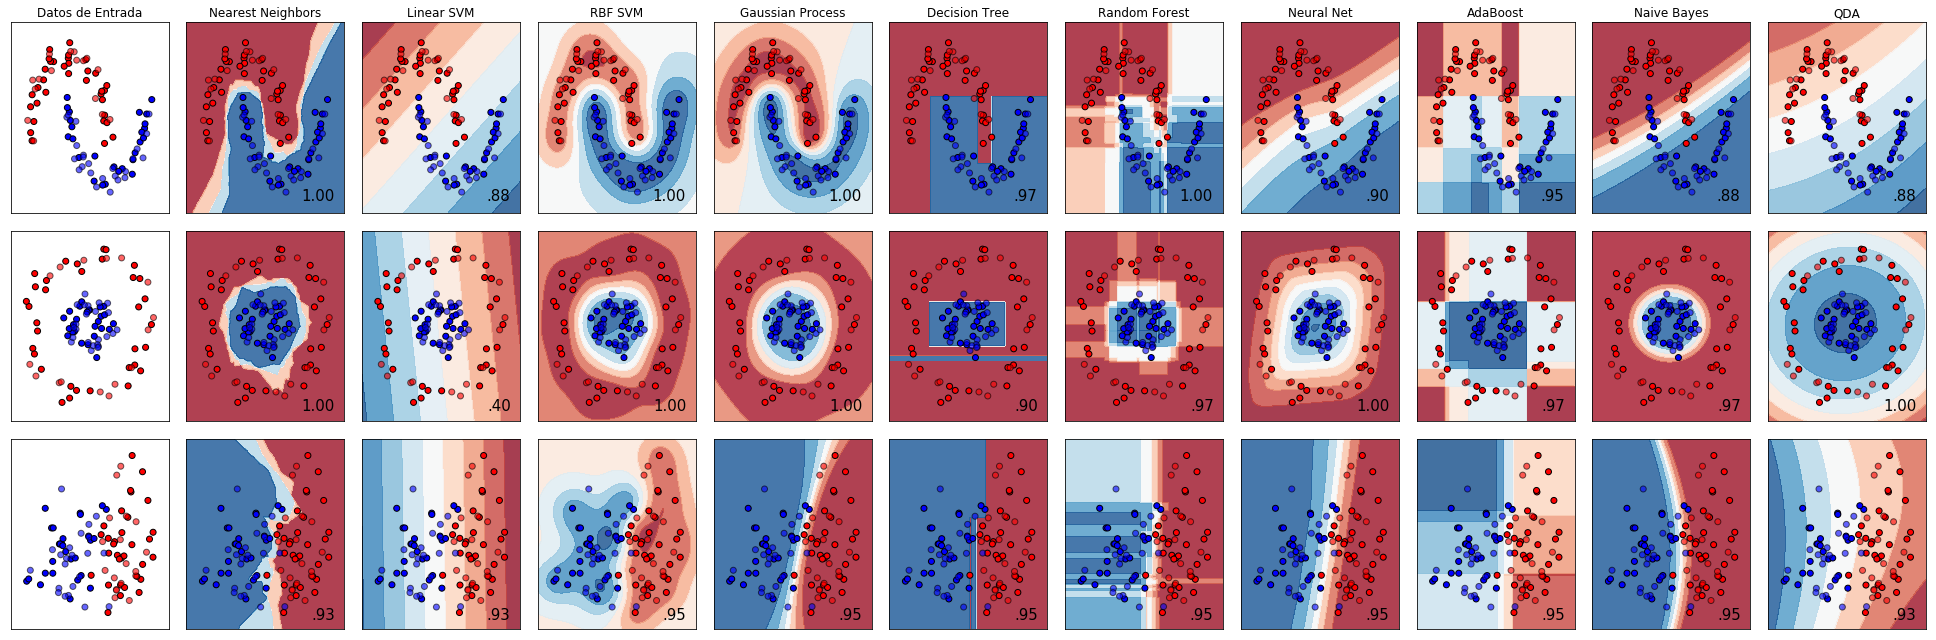

In [11]:
figure = plt.figure(figsize=(27, 9))
i = 1
h = .02 # salto de la malla
# iteramos sobre los datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocesamos el dataset, separamos en training y test
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    # creamos el mesh para graficar
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # ploteamos el dataset
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(clasificadores) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Datos de Entrada")
    
    # Ploteamos los puntos de training
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    
    # y los de test
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iteramos sobre los clasificadores
    for name, clf in zip(nombres, clasificadores):
        ax = plt.subplot(len(datasets), len(clasificadores) + 1, i)
        
        # entrenamos.... y calculamos el accuracy
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Graficamos los 'limites de decision'. 
        # Para esto hay que asignar un color a cada punto de la malla [x_min, x_max]x[y_min, y_max].
        # Hay que ver si el clasificador en el loop tiene el atributo 'decision_function'
        # sino calculamos la probabilidad de la clase
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Ponemos el resultado en el plot usando contourf
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Incluimos los puntos de train y los de test
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')

        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        
        if ds_cnt == 0:
            ax.set_title(name)
        
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

Se puede ver como, para determinados tipos de datos de entrada, son mejores algunos modelos que otros.